# Text Summarization Using NLP and Generative AI



## Install/Import Required Libraries

Make sure you have the following libraries installed:
- `transformers`
- `rouge_score`
- `bert_score`
- `matplotlib`
- `numpy`

If any are missing, install using `pip install package_name` or in a Jupyter environment `%pip install package_name`.


In [ ]:
!pip install transformers rouge_score bert_score matplotlib numpy datasets

## Imports and Basic Setup


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Transformers & NLP Libraries
from transformers import BartTokenizer, BartForConditionalGeneration
from rouge_score import rouge_scorer
from bert_score import score as bert_score

# OPTIONAL: For data collection/preprocessing from CNN/Daily Mail or other sources
# from datasets import load_dataset
# import nltk
# import spacy

model_name = 'facebook/bart-large-cnn'
model = BartForConditionalGeneration.from_pretrained(model_name)
tokenizer = BartTokenizer.from_pretrained(model_name)

print('Model and tokenizer loaded successfully!')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Model and tokenizer loaded successfully!


## Section 1: Data Acquisition & Preprocessing (Outline)

### `fetch_and_preprocess_data()`
This is an outline function to demonstrate how you might integrate CNN/Daily Mail or other sources into your pipeline. Expand it as needed.

In [ ]:
def fetch_and_preprocess_data(dataset_name='cnn_dailymail', subset='3.0.0'):
    """
    Example function to download and preprocess the CNN/Daily Mail dataset using Hugging Face datasets.
    This is an outline to demonstrate where you'd integrate data gathering steps.
    """
    try:
        # This fetches the CNN/Daily Mail dataset. (Uncomment if you want to actually load the dataset.)
        # dataset = load_dataset(dataset_name, subset)

        # For demonstration, let's just print a placeholder
        print(f"Fetching dataset: {dataset_name} (subset: {subset})")

        # Example Preprocessing Steps:
        # 1. Clean metadata
        # 2. Tokenize, normalize text (lowercasing, removing special characters, etc.)
        # 3. Potential data augmentation strategies

        print("Preprocessing data: removing metadata, tokenizing, etc.")

        # Placeholder: Return something that looks like (inputs, summaries)
        return ["Sample input article"], ["Sample reference summary"]

    except Exception as e:
        print(f"Error fetching/preprocessing data: {str(e)}")
        return None, None

# Example usage (uncomment and run if you want to actually use it)
# articles, references = fetch_and_preprocess_data()
# print(articles, references)

## Section 2: Summarization and Evaluation

The main function, `summarize_and_evaluate()`, takes an input text and a reference summary, then:
- Generates an abstractive summary using a BART model.
- Evaluates the generated summary against the reference using **ROUGE** and **BERTScore**.
- Calls helper functions to display metrics and visualize them.


In [ ]:
def summarize_and_evaluate(
    text,
    reference_summary,
    max_length=150,
    min_length=30,
    num_beams=6,
    no_repeat_ngram_size=1,
    length_penalty=1.0
):
    """

    :param text: String, the input text to summarize.
    :param reference_summary: String, the ground-truth/reference summary for evaluation.
    :param max_length: int, maximum length of the generated summary.
    :param min_length: int, minimum length of the generated summary.
    :param num_beams: int, beam search parameter for controlling quality/performance.
    :param no_repeat_ngram_size: int, repetition penalty param for generation.
    :param length_penalty: float, length penalty. >1.0 encourages longer summaries, <1.0 shorter.
    :return: dict containing generated summary and evaluation metrics.
    """
    if not text:
        return {"error": "No text provided"}

    try:
        # Tokenize the input text
        inputs = tokenizer(
            text,
            max_length=1024,
            return_tensors="pt",
            truncation=True,
            padding=True
        )

        # Generate summary
        summary_ids = model.generate(
            inputs['input_ids'],
            max_length=max_length,
            min_length=min_length,
            length_penalty=length_penalty,
            num_beams=num_beams,
            early_stopping=True,
            no_repeat_ngram_size=no_repeat_ngram_size,
            do_sample=False,
            temperature=1.0
        )

        # Decode the generated summary
        generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

        # Evaluation Metrics
        metrics = {}

        # ROUGE Score
        rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        rouge_scores = rouge_scorer_obj.score(reference_summary, generated_summary)
        metrics["rouge"] = {key: score.fmeasure for key, score in rouge_scores.items()}

        # BERTScore
        bert_precision, bert_recall, bert_f1 = bert_score([
            generated_summary
        ], [reference_summary], lang="en", verbose=False)
        metrics["bertscore"] = {
            "precision": bert_precision.item(),
            "recall": bert_recall.item(),
            "f1": bert_f1.item(),
        }

        # Print and plot outputs (console-based)
        display_results(generated_summary, metrics)

        return {
            "generated_summary": generated_summary,
            "metrics": metrics
        }
    except Exception as e:
        return {"error": str(e)}

### Display & Visualization Helpers

These functions:
- `display_results(summary, metrics)`: Print the generated summary and metrics.
- `plot_metrics(metrics)`: Plot bar charts for ROUGE and BERTScore.
- `compare_metrics(metrics)`: Radar chart comparing the two sets of metrics.


In [ ]:
def display_results(summary, metrics):
    """
    Print metrics to the console and plot ROUGE / BERTScore results.
    """
    print("\nGenerated Summary:\n")
    print(summary)
    print("\nEvaluation Metrics:\n")
    for metric, values in metrics.items():
        print(f"{metric.upper()}:")
        for key, value in values.items():
            print(f"  {key}: {value:.4f}")
    print("\n")

    # Create bar charts for metrics
    plot_metrics(metrics)
    # Compare them on a radar chart
    compare_metrics(metrics)

def plot_metrics(metrics):
    """
    Plots bar charts for ROUGE and BERTScore metrics.
    """
    # ROUGE Metrics Bar Plot
    rouge_keys = ['rouge1', 'rouge2', 'rougeL']
    rouge_values = [metrics["rouge"][key] for key in rouge_keys]

    plt.figure(figsize=(8, 5))
    plt.bar(rouge_keys, rouge_values, color=['#66c2a5', '#fc8d62', '#8da0cb'], edgecolor='black')
    plt.title("ROUGE Scores", fontsize=16)
    plt.ylabel("F1 Score", fontsize=14)
    plt.ylim(0, 1)
    plt.xticks(fontsize=12)
    plt.tight_layout()
    plt.show()

    # BERTScore Metrics Bar Plot
    bert_keys = ["precision", "recall", "f1"]
    bert_values = list(metrics["bertscore"].values())

    plt.figure(figsize=(8, 5))
    plt.bar(bert_keys, bert_values, color=['#1b9e77', '#d95f02', '#7570b3'], edgecolor='black')
    plt.title("BERTScore Metrics", fontsize=16)
    plt.ylabel("Score", fontsize=14)
    plt.ylim(0, 1)
    plt.xticks(fontsize=12)
    plt.tight_layout()
    plt.show()

def compare_metrics(metrics):
    """
    Compare ROUGE and BERTScore metrics on a radar chart for visual analysis.
    """
    categories = ['rouge1', 'rouge2', 'rougeL', 'precision', 'recall', 'f1']
    values = ([metrics['rouge'][k] for k in ['rouge1', 'rouge2', 'rougeL']] +
              [metrics['bertscore'][k] for k in ['precision', 'recall', 'f1']])
    values += values[:1]  # Close the radar chart circle

    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]  # Repeat the first angle to close the circle

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.fill(angles, values, color='cyan', alpha=0.25)
    ax.plot(angles, values, color='blue', linewidth=2)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=10)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=12)
    ax.set_title("ROUGE vs. BERTScore Comparison", fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()


## Section 3: Example Usage
Run this cell to **input text** and **use a predefined reference summary** for quick testing.

Enter text to summarize: The Rise of Renewable Energy: Transforming the Global Energy Landscape  The global energy sector has been undergoing a paradigm shift, transitioning from fossil fuels to renewable energy sources. This transformation, driven by environmental, economic, and social imperatives, is shaping a sustainable future for humanity. Renewable energy, derived from natural processes replenished on a human timescale, includes sources like solar, wind, hydropower, geothermal, and biomass. These sources have emerged as key players in mitigating climate change, reducing dependence on finite resources, and promoting energy security.  The Environmental Urgency The environmental impact of fossil fuels, including greenhouse gas emissions, air pollution, and ecosystem degradation, has reached alarming levels. Climate change, manifested through rising global temperatures, melting polar ice caps, and extreme weather events, underscores the urgency of reducing carbon footprints. Renewabl

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Generated Summary:

Renewable energy sources have emerged as key players in mitigating climate change. They can also reduce dependence on finite resources, and promoteEnergy security for countries without significant fossil fuel reserves,. But challenges persist including infrastructure upgrades to integrate renewables into existing power grids; mining of materials raises ethical concerns); financing remains a major hurdle: Developed nations often lack the financial tools or funding mechanisms that would help them develop large-scale renewable projects like solar photovoltaic panels (PV) The future is bright because it will be driven by technological advancements with growing awareness about environmental issues and carbon emissions from industry & transportation sectors suchas hydrogen capture technologies., writes Andrew Kucharski at World Resources Institute ("WRI"). Wriothesley says

Evaluation Metrics:

ROUGE:
  rouge1: 0.3615
  rouge2: 0.0698
  rougeL: 0.1538
BERTSCORE:
  precis

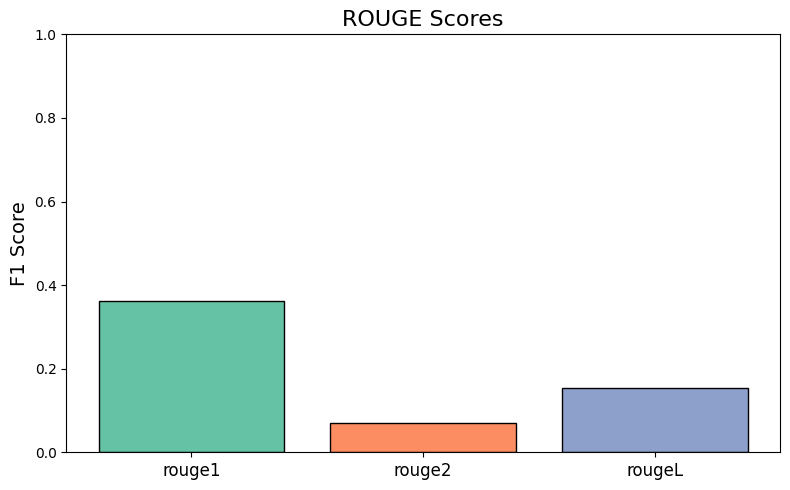

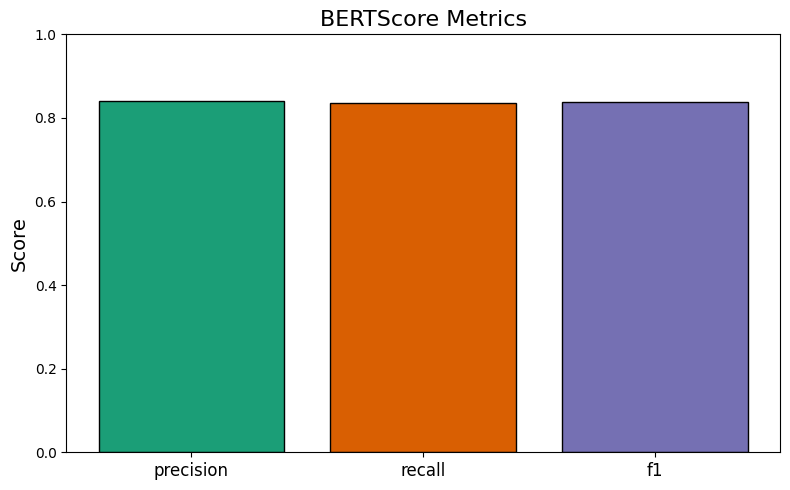

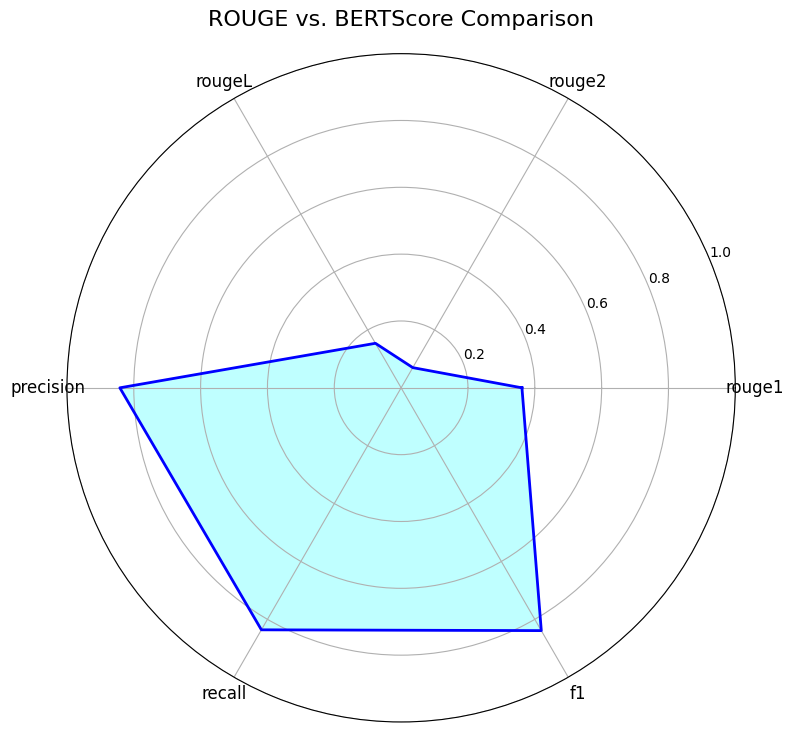

In [ ]:
if __name__ == "__main__":
    # If running inside a Jupyter notebook, this condition might not hold. You can directly call the function.
    text = input("Enter text to summarize: ")

    reference_summary = """
    The global energy sector is undergoing a significant shift towards renewable energy sources, driven by the need
    to combat climate change, enhance energy security, and foster economic growth. Renewable energy sources like solar,
    wind, and hydropower offer clean alternatives to fossil fuels, reducing greenhouse gas emissions and mitigating
    environmental damage. Technological advancements have made renewables cost-competitive, creating jobs and attracting
    investment worldwide.

    Despite their benefits, renewables face challenges such as integration into existing grids and ethical concerns over
    material extraction. Strong policy frameworks and international cooperation are essential to address these barriers.
    Renewable energy also holds transformative potential for developing countries, providing off-grid solutions to bridge
    the energy gap.

    Looking ahead, innovations in green hydrogen, energy storage, and AI will further strengthen renewable energy systems.
    Collaboration among stakeholders is crucial to achieving net-zero emissions and securing a sustainable energy future.
    """

    result = summarize_and_evaluate(text, reference_summary)

    if "error" in result:
        print("\nError:\n", result["error"])
